In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm

import matplotlib.pyplot as plt

import os
import datetime

### Read in Data

In [2]:
# Read in the bid-ask data from WRDS
bid_ask_df = pd.read_sas('../Data/dataset.sas7bdat')
# print(bid_ask_df.shape)
bid_ask_df.head()

,PERMNO,DATE,BID,ASK,BIDLO,ASKHI,VOL,PRC,decile_category,stock_num
0,10028.0,2000-01-03,5.6250,6.12500,5.75000,6.3750,3500.0,6.00000,1.0,1.0
1,10514.0,2000-01-03,10.4375,10.56250,10.12500,10.5000,368119.0,10.50000,1.0,3.0
2,10656.0,2000-01-03,11.0000,11.25000,11.00000,11.0000,799.0,11.00000,1.0,4.0
3,10661.0,2000-01-03,1.6250,1.65625,1.37500,1.8125,52683.0,1.65625,1.0,5.0
4,10838.0,2000-01-03,1.0000,1.06250,0.90625,1.0625,127077.0,1.06250,1.0,6.0


In [3]:
# test = bid_ask_df[['DATE', 'PRC']].groupby(['DATE']).sum()
# test.plot()

In [3]:
bid_ask_df.describe()

,PERMNO,BID,ASK,BIDLO,ASKHI,VOL,PRC,decile_category,stock_num
count,957126.000000,957126.000000,957126.000000,957126.000000,957126.000000,9.571260e+05,957126.000000,957126.000000,957126.000000
mean,12936.268298,31.136456,31.320395,30.811061,31.621592,1.035989e+06,29.989586,5.591417,10.480516
std,5051.415487,56.686098,56.912575,56.265678,57.318991,5.346111e+06,57.464070,2.856695,5.817942
min,10026.000000,0.001000,0.060000,0.000500,0.060000,0.000000e+00,-332.625000,1.000000,1.000000
25%,10661.000000,8.030000,8.120000,7.910000,8.250000,1.162800e+04,7.040000,3.000000,5.000000
50%,11565.000000,18.910000,19.090000,18.700001,19.290001,7.310000e+04,18.270000,6.000000,10.000000
75%,12331.000000,36.310001,36.450001,35.860001,36.869999,3.752000e+05,36.049999,8.000000,16.000000
max,43334.000000,1220.579956,1220.589966,1214.430054,1228.319946,5.929250e+08,1218.380005,10.000000,20.000000


In [4]:
# Read in the CCI data
CCI_df = pd.read_csv('../Data/CCI.csv')
# print(CCI_df.shape)
CCI_df.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-01,99.75915,NaN
1,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-02,99.74998,NaN
2,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-03,99.88835,NaN
3,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-04,99.95676,NaN
4,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-05,100.01380,NaN


In [5]:
# Read in the ICS data
ICS_df = pd.read_csv('../Data/ICS.csv')
# print(ICS_df.shape)
ICS_df.head()

,Month,YYYY,ICS_ALL
0,November,1952,86.2
1,February,1953,90.7
2,August,1953,80.8
3,November,1953,80.7
4,February,1954,82.0


### Helper Functions

In [7]:
def bid_ask_estimate(df, id_col='PERMNO', date_col='DATE', high_col='ASKHI', low_col='BIDLO'):
    """
    Inputs:
     - df [DataFrame]: contains all data
     - id_col [str]: name of stock identifying column
     - date_col [str]: name of date column
     - high_col [str]: name of column for high price
     - low_col [str]: name of column for low price
    
    Return: modifies df input to contain the Corwin-Schultz estimate of the bid-ask spread
    """
    
    temp = bid_ask_df.copy()
    temp.sort_values(['PERMNO', 'DATE'])
    temp["next_H"] = temp.groupby(['PERMNO'])['ASKHI'].shift(-1) # Get high for next day
    temp["next_L"] = temp.groupby(['PERMNO'])['BIDLO'].shift(-1) # get low for next day
    
    # beta = E{sum(j=0,1)[ln(H_(t+j)/L_(t+j))]^2} where H_t is the observed high price on day t (similarly for L)
    beta = (np.log(temp[high_col]/temp[low_col])**2 + np.log(temp.next_H/temp.next_L)**2)
    
    # gamma = [ln(H_(t, t+1)/L_(t, t+1))]^2 where H_(t, t+1) is the high price over days t and t+1 (similarly for L)
    gamma = (np.log(np.maximum(temp[high_col], temp.next_H)/np.minimum(temp[low_col], temp.next_L)))**2
    
    # alpha = ((2beta)^0.5-beta^0.5)/(3-2*2^0.5) - (gamma/(3-2*2^0.5))^0.5
    alpha = (np.sqrt(2*beta)-np.sqrt(beta))/(3-2*np.sqrt(2))-np.sqrt(gamma/(3-2*np.sqrt(2)))
    
    # high-low spread estimate S = 2(e^alpha - 1)/(1+e^alpha)
    S = 2*(np.exp(alpha)-1)/(1+np.exp(alpha))
    
    temp['CW_spread_estimate'] = S
    
    return temp

In [8]:
def split_date_field(df, date_field):
    '''
    Extracts year and month columns from date column
    
    Return: df with month and year columns
    '''
    new_df = df.copy()
    
    split_date = new_df[date_field].str.split('-', n=1, expand=True)
    
    new_df['Year'] = split_date[0].astype(int)
    new_df['Month'] = split_date[1].astype(int)
    
    return new_df
    
def get_integer_month(df, month_field, short_names=False):
    '''
    Get months as integers from string month field
    
    Return: df with updated month field to have integer values
    '''
    
    new_df = df.copy()
    
    # Check for integer months
    if pd.api.types.is_integer_dtype(df[month_field]):
        print("Month field already in integer form.")
        return df
    
    # If not integer months, convert months to integers
    if short_names:
        new_df[month_field] = new_df[month_field].apply(lambda x: datetime.datetime.strptime(x, "%b").month)
    
    else:
        new_df[month_field] = new_df[month_field].apply(lambda x: datetime.datetime.strptime(x, "%B").month)

    return new_df

In [9]:
def get_daily_data(df, trading_days, year_field, month_field, cols_to_keep=None):
    '''
    Interpolates the data on a daily basis from a monthly basis (same value between dates)
    
    Return: df with daily data
    '''
    
    trading_months = trading_days.month
    trading_years = trading_days.year
    date_df = pd.DataFrame({'Date': trading_days, 'Year': trading_years, 'Month': trading_months})
    
    if cols_to_keep:
        merged_df = date_df.merge(df[cols_to_keep+[year_field]+[month_field]], left_on=['Year', 'Month'], 
                                  right_on=[year_field, month_field], how='left')
    
    else:
        merged_df = date_df.merge(df, left_on=['Year', 'Month'], 
                                  right_on=[year_field, month_field], how='left')        
    
    return merged_df

### Pre-process the Data

#### (0) Australian Data

In [10]:
# Australian confidence index
CCI_data_AUS = CCI_df[CCI_df.LOCATION == 'AUS']
CCI_data_AUS = split_date_field(CCI_data_AUS, 'TIME')
CCI_data_AUS = CCI_data_AUS.groupby(['TIME']).mean()[['Value', 'Year', 'Month']].reset_index()

#### (i) CCI & ICS data

In [11]:
# Extract month and year, then average the CCI data across each state
CCI_data_cleaned = CCI_df[CCI_df.LOCATION == 'USA']
CCI_data_cleaned = split_date_field(CCI_data_cleaned, 'TIME')
CCI_data_cleaned = CCI_data_cleaned.groupby(['TIME']).mean()[['Value', 'Year', 'Month']].reset_index()

# Get the integer monthly values for ICS data
ICS_data_cleaned = get_integer_month(ICS_df, 'Month')

# Get trading days
trading_days = pd.to_datetime(bid_ask_df.DATE.unique().astype(str))

# Get daily data for CCI and ICS
CCI_daily = get_daily_data(CCI_data_cleaned, trading_days, 'Year', 'Month')
ICS_daily = get_daily_data(ICS_data_cleaned, trading_days, 'YYYY', 'Month')

# Get rid of unnecessary columns, rename columns
CCI_daily = CCI_daily.drop(['Year', 'TIME'], axis=1)
CCI_daily = CCI_daily.rename({'Value': 'CCI'}, axis='columns')

ICS_daily = ICS_daily.drop(['Year', 'YYYY'], axis=1)
ICS_daily = ICS_daily.rename({'ICS_ALL': 'ICS'}, axis='columns')

#### (ii) bid-ask data

In [12]:
# Convert date field to datetime
bid_ask_df['DATE'] = pd.to_datetime(bid_ask_df.DATE.astype(str))

# Get the absolute and relative bid-ask spread data
bid_ask_df['ABS_SPREAD'] = bid_ask_df.ASK - bid_ask_df.BID
bid_ask_df['REL_SPREAD'] = (bid_ask_df.ASK - bid_ask_df.BID)*2/(bid_ask_df.ASK + bid_ask_df.BID)

# Get the equal-weighted averages of firm-specific daily closing quoted spreads
bid_ask_spread = bid_ask_df[['DATE', 'decile_category', 'ABS_SPREAD', 'REL_SPREAD']].groupby(['DATE', 'decile_category']).mean().reset_index()

In [13]:
bid_ask_df[bid_ask_df.REL_SPREAD < 0]

,PERMNO,DATE,BID,ASK,BIDLO,ASKHI,VOL,PRC,decile_category,stock_num,ABS_SPREAD,REL_SPREAD
903,10656.0,2000-03-31,9.000000,8.312500,8.125000,9.625000,180026.0,9.000000,1.0,4.0,-0.687500,-0.079422
11525,10514.0,2003-04-08,2.700000,2.690000,2.610000,2.870000,57365.0,2.760000,1.0,3.0,-0.010000,-0.003711
12158,10838.0,2003-06-09,2.430000,2.420000,2.290000,2.500000,260662.0,2.470000,1.0,6.0,-0.010000,-0.004124
12368,10838.0,2003-06-27,1.960000,1.950000,1.950000,2.090000,122119.0,1.950000,1.0,6.0,-0.010000,-0.005115
12380,10514.0,2003-06-30,5.150000,5.120000,5.090000,5.790000,945201.0,5.150000,1.0,3.0,-0.030000,-0.005842
...,...,...,...,...,...,...,...,...,...,...,...,...
955146,10104.0,2019-08-12,53.230000,53.189999,53.000000,53.790001,6580115.0,53.250000,10.0,1.0,-0.040001,-0.000752
955149,10145.0,2019-08-12,164.910004,164.820007,164.419998,166.870407,1490149.0,164.690002,10.0,4.0,-0.089996,-0.000546
955154,11308.0,2019-08-12,53.180000,53.150002,52.990002,53.435001,6588611.0,53.200001,10.0,9.0,-0.029999,-0.000564
955162,11850.0,2019-08-12,69.610001,69.570000,69.330002,70.160004,9542598.0,69.629997,10.0,17.0,-0.040001,-0.000575


In [27]:
# Volume calculation

import warnings
warnings.filterwarnings("ignore")

# Get relevant columns
bid_ask_vol = bid_ask_df[['PERMNO', 'DATE', 'decile_category', 'VOL', 'PRC']].copy()

# Get the dollar volume for the previous day
bid_ask_vol = bid_ask_vol.sort_values(['PERMNO', 'DATE'])
bid_ask_vol['DLR_VOL'] = bid_ask_vol.groupby('PERMNO')['VOL'].shift(1)*bid_ask_vol.groupby('PERMNO')['PRC'].shift(1)

# Get average dollar volume across each decile
bid_ask_vol = bid_ask_vol[['DATE', 'decile_category', 'DLR_VOL']].groupby(['DATE', 'decile_category']).mean().reset_index()

bid_ask_vol = bid_ask_vol.sort_values(['decile_category', 'DATE'])

# Detrend the volume using the average over last 252 days
for i, group in bid_ask_vol.groupby('decile_category'):
    if i == 1:
        vol_data = group
        vol_data['avg_vol'] = group.DLR_VOL.rolling(252).mean()
    else:
        group['avg_vol'] = group.DLR_VOL.rolling(252).mean()
        vol_data = pd.concat([vol_data, group])
        
# Calculate the detrended volume
vol_data['vol_detrend'] = vol_data.DLR_VOL/vol_data.avg_vol

vol_data['LN_DLR_VOL'] = np.log(vol_data.vol_detrend)

In [ ]:
# Variance (orig)
import warnings
warnings.filterwarnings("ignore")

bid_ask_var = bid_ask_df[['DATE', 'PERMNO', 'decile_category', 'PRC']].copy()
bid_ask_var = bid_ask_var.groupby(['DATE', 'decile_category']).sum().reset_index()

bid_ask_var = bid_ask_var.sort_values(['decile_category', 'DATE'])
bid_ask_var['PRC_shifted'] = bid_ask_var.groupby('decile_category')['PRC'].shift(1)
bid_ask_var['daily_return'] = (bid_ask_var.PRC-bid_ask_var.PRC_shifted)/bid_ask_var.PRC_shifted

# Get the variances based on 21-day periods within each decile
for i, group in bid_ask_var.groupby('decile_category'):
    if i == 1:
        res = group
        res['ret_var'] = group.daily_return.rolling(21).var()
    else:
        group['ret_var'] = group.daily_return.rolling(21).var()
        res = pd.concat([res, group])

# Get the 252-day average variances within each decile
for i, group in res.groupby('decile_category'):
    if i == 1:
        final = group
        final['avg_var_252'] = group.ret_var.rolling(252).mean()
    else:
        group['avg_var_252'] = group.ret_var.rolling(252).mean()
        final = pd.concat([final, group])
        
# Calculate the detrended variance
final['var_detrend'] = final.ret_var/final.avg_var_252
final['std_detrend'] = np.sqrt(final.var_detrend)

# Remove unnecessary columns
final = final.drop(['PRC', 'PRC_shifted','ret_var', 'avg_var_252'], axis=1)

In [133]:
# Variance and Return Calculation
import warnings
warnings.filterwarnings("ignore")
# Start with returns calculated on each stock
# Then, decide for equal weighted or value weighted on the returns in the decile
# Potential robustness check: value weighted instead of equal weighted (shouldn't make a bid difference since working with deciles)

# Negative prices - omit? CRPS meaning - signal no closing price was available for that period (instead bid-ask average was used)
# Approach 1: Always use absolute value of negative prices (cite CRSP manual, note that it is not quite the closing price)
# # # consequences for calculation of bid-ask spreads (will be half of what it shoukd be, might need to double - DOCUMENT THISS AND CHECK CRSP!!)

bid_ask_var = bid_ask_df[['DATE', 'PERMNO', 'decile_category', 'PRC']].copy()

# Get the individual stock returns for each stock
i = 1
bid_ask_var = bid_ask_var.sort_values(['PERMNO', 'DATE'])
for permno, group in bid_ask_var.groupby('PERMNO'):
    if i == 1:
        bid_ask_return = group
        bid_ask_return['PRC_shifted'] = group['PRC'].shift(1) # Shifted price
        bid_ask_return['daily_return'] = (bid_ask_return.PRC-bid_ask_return.PRC_shifted)/abs(bid_ask_return.PRC_shifted) # Return
    else:
        group['PRC_shifted'] = group['PRC'].shift(1) # Shifted price
        bid_ask_return['daily_return'] = (bid_ask_return.PRC-bid_ask_return.PRC_shifted)/abs(bid_ask_return.PRC_shifted) # Return
        bid_ask_return = pd.concat([bid_ask_return, group])
    i += 1

# Get equal-weighted average return in each decile
bid_ask_return = bid_ask_return.dropna() # Remove NaN rows
bid_ask_return_avg = bid_ask_return.groupby(['DATE', 'decile_category']).mean().reset_index()
bid_ask_return_avg = bid_ask_return_avg[['DATE', 'decile_category', 'daily_return']] # Remove unnecessary rows

# Get the variances based on 21-day periods within each decile
for i, group in bid_ask_return_avg.groupby('decile_category'):
    if i == 1:
        res = group
        res['ret_var'] = group.daily_return.rolling(21).var()
    else:
        group['ret_var'] = group.daily_return.rolling(21).var()
        res = pd.concat([res, group])
        
# Get the 252-day average variances within each decile
for i, group in res.groupby('decile_category'):
    if i == 1:
        final = group
        final['avg_var_252'] = group.ret_var.rolling(252).mean()
    else:
        group['avg_var_252'] = group.ret_var.rolling(252).mean()
        final = pd.concat([final, group])
        
# Calculate the detrended variance
final['var_detrend'] = final.ret_var/final.avg_var_252 # Requires subtracting by 1?

# Remove unnecessary columns and remove NaN rows
final = final.drop(['ret_var', 'avg_var_252'], axis=1).dropna()

In [134]:
final.describe()

,decile_category,daily_return,var_detrend
count,47590.000000,47590.000000,47590.000000
mean,5.500000,0.001077,1.005367
std,2.872312,0.094352,1.870912
min,1.000000,-0.832962,0.001580
25%,3.000000,-0.011751,0.498867
50%,5.500000,0.000669,0.808248
75%,8.000000,0.012428,1.191807
max,10.000000,2.701543,235.398454


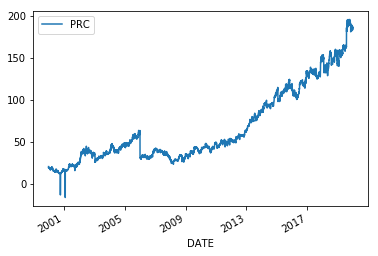

In [106]:
test1 = bid_ask_df[bid_ask_df.PERMNO == 10026][['DATE', 'PRC']].set_index('DATE')
test1.plot()

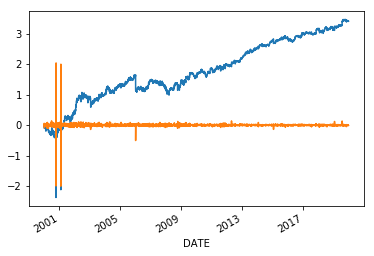

In [122]:
test = bid_ask_return[bid_ask_return.PERMNO == 10026][['DATE', 'daily_return']].reset_index().set_index('DATE')
test['cum_return'] = test['daily_return'].cumsum()
test['cum_return'].plot()
test['daily_return'].plot()

In [123]:
bid_ask_return_avg.describe()

,decile_category,daily_return
count,50300.00000,50300.000000
mean,5.50000,0.001054
std,2.87231,0.097423
min,1.00000,-0.832962
25%,3.00000,-0.012289
50%,5.50000,0.000675
75%,8.00000,0.013017
max,10.00000,2.701543


In [64]:
bid_ask_var[bid_ask_var.decile_category == 1].describe()

,PERMNO,decile_category,PRC
count,87593.000000,87593.0,87593.000000
mean,13817.823833,1.0,4.589429
std,5488.931565,0.0,8.641451
min,10028.000000,1.0,-55.445000
25%,10661.000000,1.0,1.140000
50%,12017.000000,1.0,2.750000
75%,13769.000000,1.0,6.650000
max,31051.000000,1.0,55.209999


In [30]:
final

,DATE,decile_category,daily_return,var_detrend,std_detrend
0,2000-01-03,1.0,NaN,NaN,NaN
10,2000-01-04,1.0,-0.569952,NaN,NaN
20,2000-01-05,1.0,0.021459,NaN,NaN
30,2000-01-06,1.0,1.452101,NaN,NaN
40,2000-01-07,1.0,-0.581049,NaN,NaN
...,...,...,...,...,...
50269,2019-12-24,10.0,-0.002907,0.411390,0.641397
50279,2019-12-26,10.0,0.001954,0.403750,0.635413
50289,2019-12-27,10.0,-0.000544,0.366949,0.605763
50299,2019-12-30,10.0,0.003815,0.363467,0.602882


In [31]:
# Combine bid-ask datasets
bid_ask_daily = bid_ask_spread.merge(vol_data, on=['DATE', 'decile_category'], how='left' )
bid_ask_daily = bid_ask_daily.merge(final, on=['DATE', 'decile_category'], how='left' )
bid_ask_daily = bid_ask_daily.rename({'DATE': 'Date'}, axis='columns')
bid_ask_daily

,Date,decile_category,ABS_SPREAD,REL_SPREAD,DLR_VOL,avg_vol,vol_detrend,LN_DLR_VOL,daily_return,var_detrend,std_detrend
0,2000-01-03,1.0,0.196429,0.036965,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-03,2.0,0.354687,0.043477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,3.0,0.281250,0.041424,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-03,4.0,0.425347,0.040982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-03,5.0,0.465278,0.037899,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
50305,2019-12-31,6.0,0.037500,0.001071,4.254916e+06,5.314378e+06,0.800642,-0.222341,0.000200,0.604960,0.777792
50306,2019-12-31,7.0,0.844500,0.001944,7.607546e+06,9.289716e+06,0.818921,-0.199767,0.000133,0.687120,0.828927
50307,2019-12-31,8.0,0.037000,0.000492,1.880326e+07,2.165617e+07,0.868263,-0.141260,0.000031,0.197113,0.443975
50308,2019-12-31,9.0,0.097500,0.000514,3.270178e+07,4.660941e+07,0.701613,-0.354373,0.001077,0.194467,0.440984


#### (iii) combine data

In [32]:
# Combine datasets into one dataframe
all_data = bid_ask_daily.merge(CCI_daily, on=['Date'], how='left')
all_data = all_data.merge(ICS_daily, on=['Date', 'Month'], how='left')
all_data = all_data.set_index('Date')

# Get the indicator columns for winter, (Jan - Mar), spring (Apr - Jun), summer (Jul - Sep)
all_data["Q1"] = all_data.Month.apply(lambda x: int(x >= 1 and x <= 3))
all_data["Q2"] = all_data.Month.apply(lambda x: int(x >= 3 and x <= 6))
all_data["Q3"] = all_data.Month.apply(lambda x: int(x >= 7 and x <= 9))

# Remove month field
all_data = all_data.drop(['Month'], axis='columns')

all_data_clean = all_data.dropna()

In [33]:
all_data_clean.describe()

,decile_category,ABS_SPREAD,REL_SPREAD,DLR_VOL,avg_vol,vol_detrend,LN_DLR_VOL,daily_return,var_detrend,std_detrend,CCI,ICS,Q1,Q2,Q3
count,47590.000000,47590.000000,47590.000000,4.759000e+04,4.759000e+04,47590.000000,47590.000000,47590.000000,47590.000000,47590.000000,47590.000000,47590.000000,47590.000000,47590.000000,47590.000000
mean,5.500000,0.175345,0.011008,3.638581e+07,3.610077e+07,1.042951,-0.091947,-0.045499,1.215060,0.871649,99.709237,84.575121,0.240177,0.339357,0.253415
std,2.872312,0.211756,0.013020,9.815727e+07,9.380582e+07,0.803504,0.497564,13.674788,4.233913,0.674757,1.460758,11.448309,0.427195,0.473496,0.434971
min,1.000000,-0.062631,-0.001840,1.044808e+04,7.433555e+04,0.044422,-3.114018,-2578.004109,0.000002,0.001480,96.261090,55.300000,0.000000,0.000000,0.000000
25%,3.000000,0.066500,0.002044,9.597206e+05,1.124001e+06,0.713509,-0.337560,-0.013456,0.248406,0.498403,98.634280,76.000000,0.000000,0.000000,0.000000
50%,5.500000,0.119474,0.006319,3.543317e+06,3.815362e+06,0.932625,-0.069752,0.000588,0.664920,0.815426,100.135200,87.600000,0.000000,0.000000,0.000000
75%,8.000000,0.215263,0.015824,9.711531e+06,9.114536e+06,1.182468,0.167604,0.013277,1.209952,1.099978,100.907400,93.600000,0.000000,1.000000,1.000000
max,10.000000,13.292631,0.387691,1.198019e+09,4.627220e+08,34.521346,3.541578,194.234317,250.845109,15.838090,101.693600,103.800000,1.000000,1.000000,1.000000


In [34]:
for decile, group in all_data_clean.groupby('decile_category'):
    print(group.describe())

       decile_category   ABS_SPREAD   REL_SPREAD       DLR_VOL       avg_vol  \
count           4759.0  4759.000000  4759.000000  4.759000e+03  4.759000e+03   
mean               1.0     0.081242     0.022618  5.991113e+05  5.955782e+05   
std                0.0     0.051880     0.013115  1.031261e+06  4.143291e+05   
min                1.0     0.019410     0.005907  1.044808e+04  8.137965e+04   
25%                1.0     0.052869     0.014239  1.872191e+05  2.423101e+05   
50%                1.0     0.071105     0.019018  3.609815e+05  4.519846e+05   
75%                1.0     0.098235     0.026940  6.320247e+05  8.376984e+05   
max                1.0     2.300000     0.181073  2.036745e+07  1.848819e+06   

       vol_detrend   LN_DLR_VOL  daily_return  var_detrend  std_detrend  \
count  4759.000000  4759.000000   4759.000000  4759.000000  4759.000000   
mean      1.065571    -0.256725     -0.195406     1.423475     0.858299   
std       1.385343     0.728270     21.328452     5.70

### Visualize Data

In [35]:
def plot(df, plot_col, groupby_col):
    plt.figure()
    plot_df = df.pivot(columns=groupby_col, values=plot_col)
    plot_df.plot(ylim=(0,0.2), title='RSpread by Decile', figsize=(15,10))
    return

<Figure size 432x288 with 0 Axes>

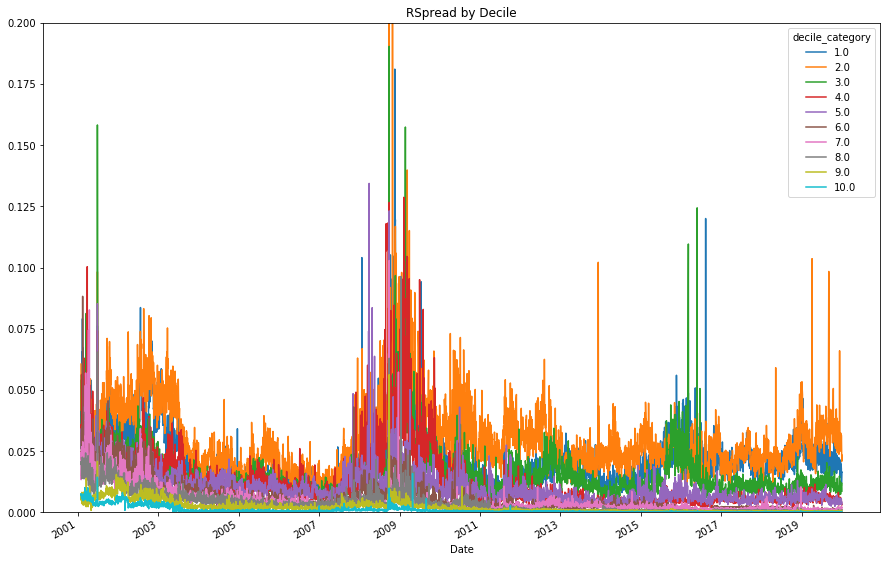

In [36]:
# average bid-ask spread by decile
plot(all_data_clean, 'REL_SPREAD', 'decile_category')

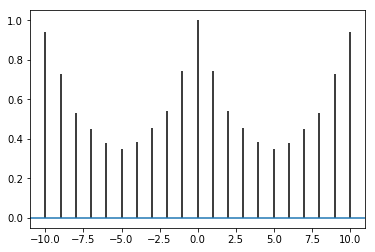

In [37]:
# autocorrelation, detrended stuff
plt.acorr(all_data_clean.REL_SPREAD)
plt.show()

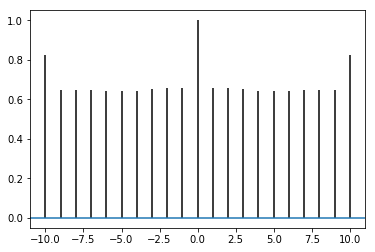

In [38]:
plt.acorr(all_data_clean.vol_detrend)
plt.show()

<Figure size 432x288 with 0 Axes>

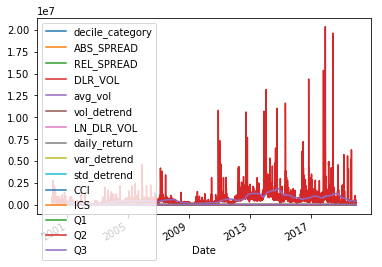

In [39]:
plt.figure()
all_data[all_data.decile_category==1].plot()

### Run Linear Regression

In [40]:
for i in range(10):
    decile_data = all_data_clean[all_data_clean.decile_category==i+1]

    X = sm.add_constant(decile_data[['LN_DLR_VOL', 'var_detrend', 'CCI', 'ICS', 'Q1', 'Q2', 'Q3']])
    Y = decile_data['REL_SPREAD']

    model = sm.OLS(Y, X).fit()
    print("\nRegression Results for Decile", i+1)
    print(model.summary())


Regression Results for Decile 1
                            OLS Regression Results                            
Dep. Variable:             REL_SPREAD   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     84.83
Date:                Tue, 02 Feb 2021   Prob (F-statistic):          1.08e-116
Time:                        14:54:15   Log-Likelihood:                 14154.
No. Observations:                4759   AIC:                        -2.829e+04
Df Residuals:                    4751   BIC:                        -2.824e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0

In [42]:
for i in range(10):
    decile_data = all_data_clean[all_data_clean.decile_category==i+1]

    X = sm.add_constant(decile_data[['LN_DLR_VOL', 'var_detrend', 'ICS', 'Q1', 'Q2', 'Q3']])
    Y = decile_data['REL_SPREAD']

    model = sm.OLS(Y, X).fit()
    print("\nRegression Results for Decile", i+1)
    print(model.summary())


Regression Results for Decile 1
                            OLS Regression Results                            
Dep. Variable:             REL_SPREAD   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     98.76
Date:                Tue, 02 Feb 2021   Prob (F-statistic):          1.94e-117
Time:                        17:33:10   Log-Likelihood:                 14153.
No. Observations:                4759   AIC:                        -2.829e+04
Df Residuals:                    4752   BIC:                        -2.825e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0